In [31]:
from utility import format_missing_values, features_selection, preprocessing_text

import numpy as np
from tqdm import tqdm
import pandas as pd
import random
tqdm.pandas()

import seaborn as sns
import matplotlib.pyplot as plt

from joblib import dump, load

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import naive_bayes, pipeline, metrics

from lime import lime_text

## TF-IDF
$TF-IDF(t, d) = TF(t, d) * log(N/(DF + 1))$


### Load already preprocessed data

In [32]:
X_train, X_test = pd.read_csv('../Data/X_train_preprocessed.csv'), pd.read_csv('../Data/X_test_preprocessed.csv')
y_train, y_test = pd.read_csv('../Data/y_train.csv'), pd.read_csv('../Data/y_test.csv')

In [6]:
category_list = list(y_train['main_cat'].unique())

### TF-IDF algorithm

In [33]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=10000)
corpus = X_train['feature'].fillna('')
vect_train = vectorizer.fit_transform(tqdm(corpus))
dict_vocabulary = vectorizer.vocabulary_
print('The length of the vocabulary is:', len(dict_vocabulary))

100%|██████████| 998733/998733 [08:51<00:00, 1877.35it/s] 


The length of the vocabulary is: 10000


### Train Naive Bayes classifier

In [34]:
classifier = naive_bayes.MultinomialNB()

In [35]:
## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),("classifier", classifier)])

model["classifier"].fit(vect_train, y_train)

/Users/dderosso/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()

### Test performance

In [36]:
predicted = model.predict(X_test['feature'].fillna(' '))

In [7]:
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
print("Accuracy:",  round(accuracy,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))

Accuracy: 0.73
Detail:
                           precision    recall  f1-score   support

          All Electronics       0.49      0.32      0.39     10576
           Amazon Fashion       0.74      0.78      0.76     11949
              Amazon Home       0.63      0.67      0.65     14273
    Arts, Crafts & Sewing       0.74      0.77      0.75     14511
               Automotive       0.79      0.83      0.81     14687
                    Books       0.81      0.77      0.79     13937
           Camera & Photo       0.75      0.81      0.78      7337
Cell Phones & Accessories       0.75      0.82      0.78     11886
                Computers       0.70      0.69      0.69     13431
            Digital Music       0.83      0.86      0.85      9664
                  Grocery       0.94      1.00      0.97     14037
   Health & Personal Care       0.49      0.07      0.13      2823
     Home Audio & Theater       0.51      0.69      0.59      6680
  Industrial & Scientific       0.60  

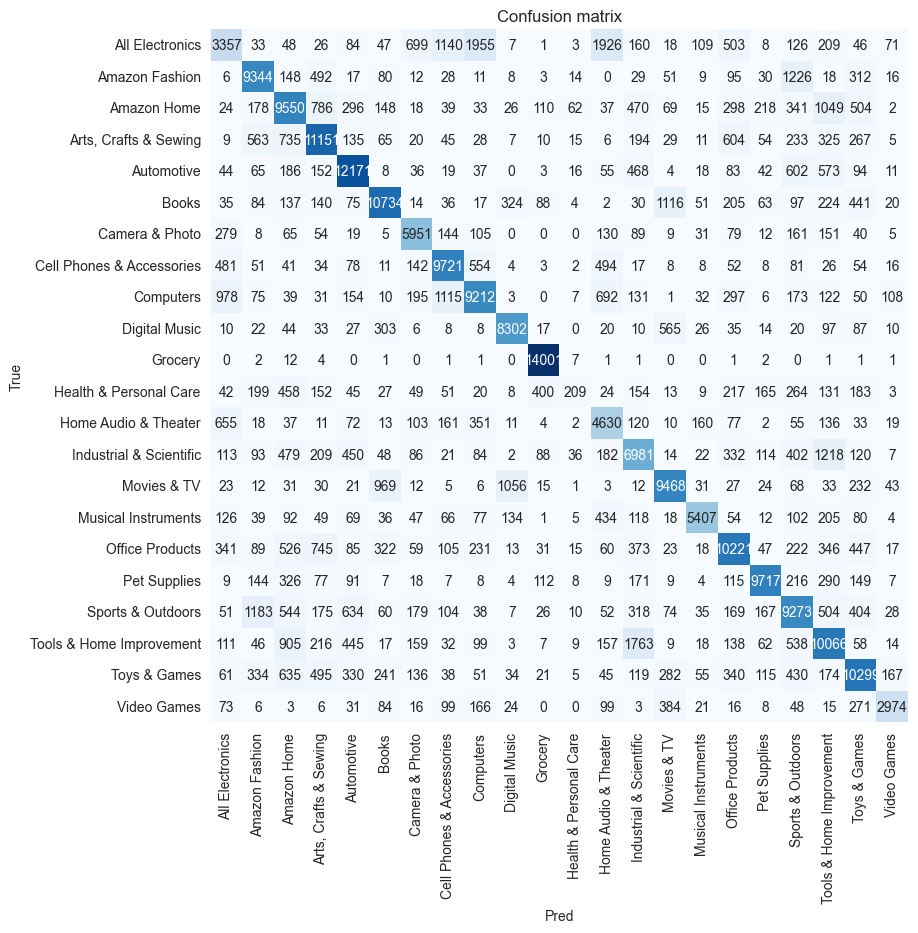

In [19]:
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues,
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=np.unique(y_test),
       yticklabels=np.unique(y_test), title="Confusion matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

#### Save model (pipeline)

In [37]:
# Save the pickled pipeline
dump(model, '../Models/tf_idf_pipeline_v2.joblib')

['../Models/tf_idf_pipeline_v2.joblib']

### Explainability test

In [106]:
i = random.randint(0, len(X_test))
example = X_test['feature'][i]
example = preprocessing_text(example)
example_pred = model.predict([example])
example_pred_prob = model.predict_proba([example])

print("True:", y_test.iloc[i][0], "--> Pred:", predicted[i], "| Prob:", round(np.max(example_pred_prob),2))

explainer = lime_text.LimeTextExplainer(class_names=np.unique(y_train['main_cat']))
explained = explainer.explain_instance(example, model.predict_proba)
explained.show_in_notebook(text=example)

True: Amazon Fashion --> Pred: Amazon Fashion | Prob: 0.68
